# MIOFlow

## Workflow
1. Load pre-processed SERGIO simulation AnnData
2. Train a **GAGA autoencoder** (`gaga.py`) — learns a geometry-preserving latent embedding from PCA, regularised by PHATE distances
3. Pass the trained GAGA model to `MIOFlow` and call `fit()` — trains a Neural ODE in GAGA latent space using optimal transport
4. Inspect losses and trajectories
5. `decode_to_gene_space()` — maps trajectories back through the GAGA decoder and PCA components to recover gene-level predictions

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances

sys.path.insert(0, '../MIOFlow')
from gaga import Autoencoder, train_gaga_two_phase, dataloader_from_pc
from mioflow import MIOFlow


## 1. Load Data

In [2]:
adata = sc.read_h5ad('data/sergio/SERGIO_sim_DS9.h5ad')
adata.obs['merged_pseudotime_bin'] = adata.obs['pseudotime_bin'].copy()
adata.obs['merged_pseudotime_bin'] = adata.obs['merged_pseudotime_bin'].replace({4:3, 5: 3, 6: 3, 7: 3})
adata.obs['merged_pseudotime_bin'] = adata.obs['merged_pseudotime_bin'].astype('category')
adata


AnnData object with n_obs × n_vars = 900 × 100
    obs: 'sim_time_bin', 'sim_timepoint', 'pseudotime', 'pseudotime_bin', 'merged_pseudotime_bin'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_pca'
    varm: 'PCs'

In [3]:
adata.obs['merged_pseudotime_bin'].value_counts()

merged_pseudotime_bin
3    562
0    113
2    113
1    112
Name: count, dtype: int64

Set the time_column for your dataset

In [4]:
time_column = 'pseudotime_bin' #Set the time_column for your dataset

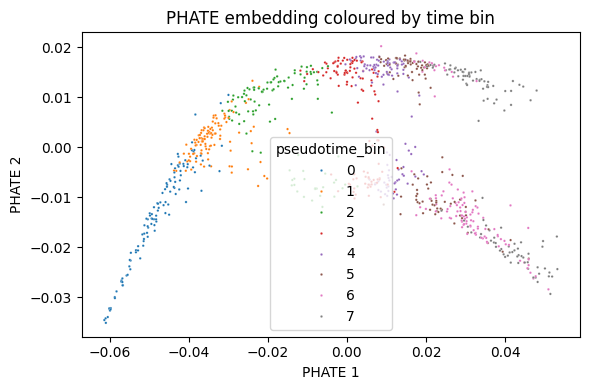

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    x=adata.obsm['X_phate'][:, 0],
    y=adata.obsm['X_phate'][:, 1],
    hue=adata.obs[time_column],
    palette='tab10',
    s=3,
    ax=ax,
)
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_title('PHATE embedding coloured by time bin')
plt.tight_layout()
plt.show()

## 2. Train GAGA Autoencoder

GAGA (`gaga.py`) trains a two-phase autoencoder on PCA embeddings, regularised by PHATE distances:

- **Phase 1** — encoder learns a geometry-preserving latent space (distance preservation loss, decoder frozen)
- **Phase 2** — decoder learns to reconstruct PCA coordinates (reconstruction loss, encoder frozen)

The resulting latent space is where the MIOFlow ODE will be trained.

In [6]:
# ── Scale PCA inputs (same normalisation used during GAGA training) ──────────
X_pca_raw  = adata.obsm['X_pca'].astype(np.float32)
scaler_pca = StandardScaler().fit(X_pca_raw)
X_pca      = scaler_pca.transform(X_pca_raw)

# ── PHATE-based pairwise distances for geometric regularisation ──────────────
scaler_phate    = StandardScaler().fit(adata.obsm['X_phate'])
X_phate_scaled  = scaler_phate.transform(adata.obsm['X_phate'])
phate_distances = pairwise_distances(X_phate_scaled, metric='euclidean').astype(np.float32)

# ── Build model + dataloader ─────────────────────────────────────────────────
input_dim  = X_pca.shape[1]   # 50 PCA components
latent_dim = 2                 # match PHATE dimensionality

gaga_model  = Autoencoder(input_dim, latent_dim, hidden_dims=[128, 64])
gaga_loader = dataloader_from_pc(X_pca, phate_distances, batch_size=1024)
print(f'GAGA architecture: {input_dim} → {latent_dim}')

# ── Two-phase training ───────────────────────────────────────────────────────
gaga_history = train_gaga_two_phase(
    gaga_model,
    gaga_loader,
    encoder_epochs=300,       # Phase 1: distance preservation
    decoder_epochs=300,       # Phase 2: reconstruction
    learning_rate=1e-3,
    dist_weight_phase1=1.0,
    recon_weight_phase2=1.0,
)

GAGA architecture: 30 → 2
Phase 1: Training encoder (decoder frozen) for distance preservation
Training GAGA on device: cpu
Encoder frozen: False, Decoder frozen: True
Reconstruction weight: 0.0, Distance weight: 1.0


Epochs: 100%|██████████| 300/300 [00:02<00:00, 117.21it/s, train_loss=0.0149, recon=1.0100, dist=0.0149]



Phase 2: Training decoder (encoder frozen) for reconstruction
Training GAGA on device: cpu
Encoder frozen: True, Decoder frozen: False
Reconstruction weight: 1.0, Distance weight: 0.0


Epochs: 100%|██████████| 300/300 [00:01<00:00, 211.61it/s, train_loss=0.8307, recon=0.8307, dist=0.0148]


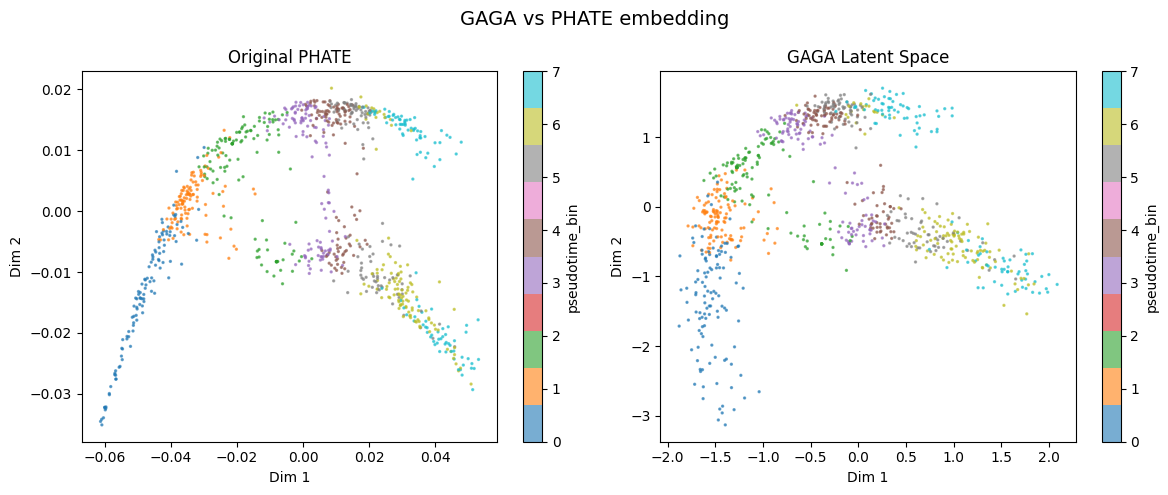

In [7]:
# ── Quick sanity-check: compare GAGA latent space with original PHATE ────────
gaga_model.eval()
with torch.no_grad():
    gaga_embeddings = gaga_model.encode(torch.tensor(X_pca)).numpy()

adata.obsm['X_gaga'] = gaga_embeddings

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, key, title in zip(
    axes,
    ['X_phate', 'X_gaga'],
    ['Original PHATE', 'GAGA Latent Space'],
):
    sc_plot = ax.scatter(
        adata.obsm[key][:, 0], adata.obsm[key][:, 1],
        c=adata.obs[time_column], cmap='tab10', s=2, alpha=0.6,
    )
    plt.colorbar(sc_plot, ax=ax, label=time_column)
    ax.set_title(title)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')

plt.suptitle('GAGA vs PHATE embedding', fontsize=14)
plt.tight_layout()
plt.show()

K-means clusters found: ['0', '1', '2', '3', '4']


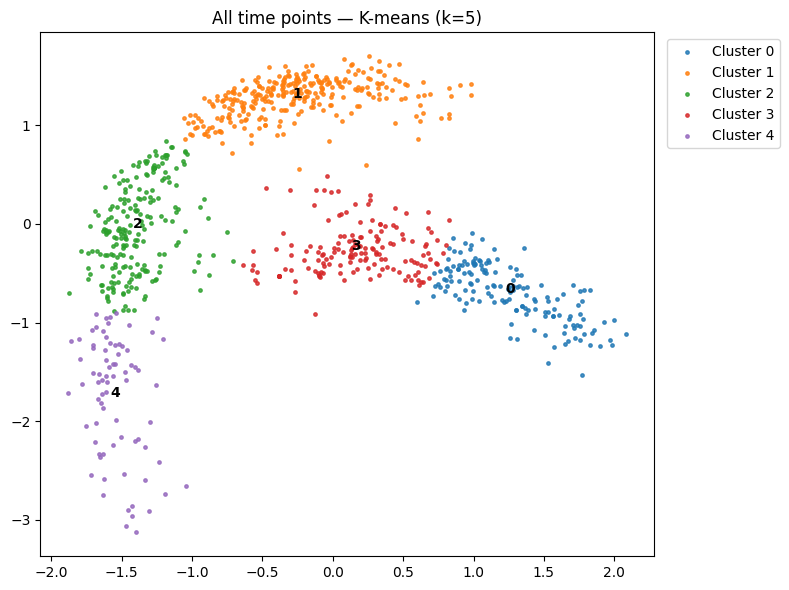

In [13]:
from sklearn.cluster import KMeans

# ── K-means clustering on ALL time points ────────────────────────────────────
X_all = adata.obsm['X_gaga']

n_clusters = 5   # ← tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_all).astype(str)
print('K-means clusters found:', sorted(set(cluster_labels), key=int))

# ── Store in adata for downstream use ─────────────────────────────────────────
adata.obs['kmeans_cluster'] = cluster_labels

# ── Visualise clusters ────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))
palette = plt.cm.tab10.colors
for cl in sorted(set(cluster_labels), key=int):
    mask_cl = cluster_labels == cl
    ax.scatter(
        X_all[mask_cl, 0], X_all[mask_cl, 1],
        s=6, alpha=0.8, color=palette[int(cl) % 10], label=f'Cluster {cl}',
    )
    centroid = X_all[mask_cl].mean(axis=0)
    ax.annotate(f'{cl}', centroid, fontsize=10, fontweight='bold', ha='center')

ax.set_title(f'All time points — K-means (k={n_clusters})')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

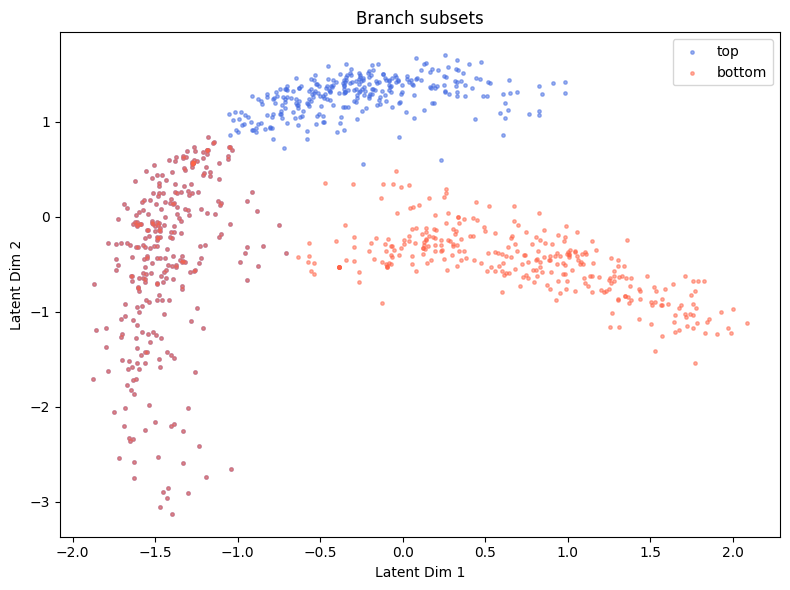

In [14]:
# ── After inspecting the plot above, map each cluster → branch(es) ───────────
# Use lists so a cluster can belong to multiple branches
cluster_to_branches = {
    '0': ['bottom'],
    '1': ['top'],
    '2': ['top', 'bottom'],  
    '3': ['bottom'],
    '4':  ['top', 'bottom'],
}

# Assign branch labels to ALL cells (no longer just final bin)
# A cell can appear in multiple branches, so we store per-branch membership
all_idx = np.arange(adata.n_obs)

adata_branches = {}
for branch_name in ['top', 'bottom']:
    # Find cells whose cluster is assigned to this branch
    branch_mask = np.array([
        cluster_labels[i] in cluster_to_branches
        and branch_name in cluster_to_branches[cluster_labels[i]]
        for i in range(adata.n_obs)
    ])
    adata_branches[branch_name] = adata[branch_mask].copy()
    counts = adata_branches[branch_name].obs[time_column].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 6))

branch_colors = {'top': 'royalblue', 'bottom': 'tomato'}

# Plot each branch subset
for branch_name, color in branch_colors.items():
    X = adata_branches[branch_name].obsm['X_gaga']
    ax.scatter(X[:, 0], X[:, 1], s=6, alpha=0.5, color=color, label=branch_name)

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_title('Branch subsets')
ax.legend()
plt.tight_layout()
plt.show()


## 3. Configure and Initialise MIOFlow

Pass the trained `gaga_model` and `scaler_pca` (the scaler fitted on `X_pca` before GAGA training).  
`MIOFlow` will use the encoder to embed cells into latent space for ODE training, and the decoder in `decode_to_gene_space()`.

In [15]:
import importlib
sys.path.insert(0, '../MIOFlow')
import mioflow
importlib.reload(mioflow)

mioflow_models = {}
for branch in ['top', 'bottom']:
    mioflow_models[branch] = mioflow.MIOFlow(
    adata_branches[branch],
    gaga_model=gaga_model,
    gaga_input_scaler=scaler_pca,    # fitted on X_pca — used for encode() and inverse_transform()
    obs_time_key=time_column,
    debug_level='info',
    #model
    hidden_dim = 64,
    use_cuda = torch.cuda.is_available(),
    use_sde = True,
    diffusion_scale = 0.1,
    diffusion_init_scale = 0.1,
    sde_dt = 0.1,
    lambda_energy_f = 1.0,
    lambda_energy_g = 0.0,
    grad_clip = 1.0,
    momentum_beta = 0.0,
    scheduler_type='cosine',
    learning_rate = 1e-3,
    scheduler_t_max=300,
    scheduler_min_lr=1e-5,
    # Training phases
    n_epochs=300,
    # Loss
    use_density_loss=True,
    lambda_ot = 1.0,
    lambda_density=0.0,
    lambda_energy=0.1,
    energy_time_steps=20,
    # Data / output
    sample_size=100,
    n_trajectories=100,
    n_bins=100,
    exp_dir='.',
)


2026-02-27 12:46:21,508 - MIOFlow - INFO - MIOFlow initialised | 587 cells, 100 genes | device=cpu
2026-02-27 12:46:21,509 - MIOFlow - INFO - MIOFlow initialised | 604 cells, 100 genes | device=cpu


## 4. Fit — `~5 minutes`

`fit()` runs three phases under the hood:
1. **Training** (`n_local_epochs`) — trains each consecutive time-point pair independently

The ODE operates entirely in the GAGA latent space.

In [16]:
mioflow_models

{'top': MIOFlow(n_obs=587, gaga=Autoencoder, n_epochs=300, trajectories=None, status=not fitted),
 'bottom': MIOFlow(n_obs=604, gaga=Autoencoder, n_epochs=300, trajectories=None, status=not fitted)}

In [17]:
for branch, model in mioflow_models.items():
    print(f'\n── Fitting branch: {branch} ──')
    model.fit()
    print(model)

2026-02-27 12:46:23,123 - MIOFlow - INFO - SDEFunc: input_dim=2, hidden_dim=64
2026-02-27 12:46:23,124 - MIOFlow - INFO - Global training: 300 epochs



── Fitting branch: top ──


Training (global): 100%|██████████| 300/300 [01:37<00:00,  3.08it/s]
2026-02-27 12:48:00,463 - MIOFlow - INFO - Trajectories generated: shape=(100, 100, 2)
2026-02-27 12:48:00,464 - MIOFlow - INFO - MIOFlow fitting completed.
2026-02-27 12:48:00,465 - MIOFlow - INFO - SDEFunc: input_dim=2, hidden_dim=64
2026-02-27 12:48:00,465 - MIOFlow - INFO - Global training: 300 epochs


MIOFlow(n_obs=587, gaga=Autoencoder, n_epochs=300, trajectories=(100, 100, 2), status=fitted)

── Fitting branch: bottom ──


Training (global): 100%|██████████| 300/300 [01:38<00:00,  3.04it/s]
2026-02-27 12:49:39,166 - MIOFlow - INFO - Trajectories generated: shape=(100, 100, 2)
2026-02-27 12:49:39,167 - MIOFlow - INFO - MIOFlow fitting completed.


MIOFlow(n_obs=604, gaga=Autoencoder, n_epochs=300, trajectories=(100, 100, 2), status=fitted)


## 4. Training Losses

After fitting:
- `mf.losses` — list of dicts `{'Total', 'OT', 'Density', 'Energy'}` per epoch (local phase)

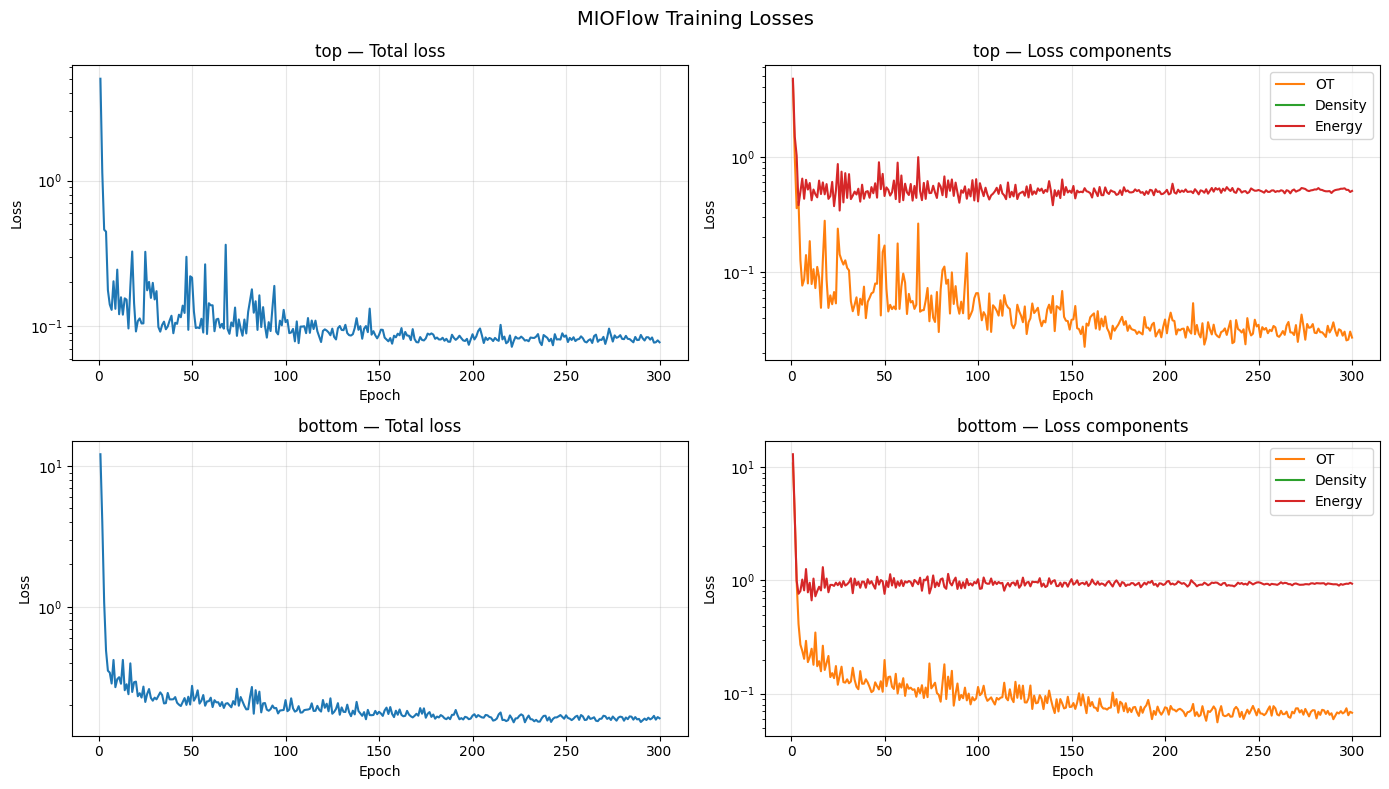

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for row, (branch, model) in enumerate(mioflow_models.items()):
    epochs = model.losses['epoch']

    axes[row, 0].plot(epochs, model.losses['total_loss'], color='tab:blue')
    axes[row, 0].set_title(f'{branch} — Total loss')
    axes[row, 0].set_xlabel('Epoch')
    axes[row, 0].set_ylabel('Loss')
    axes[row, 0].set_yscale('log')
    axes[row, 0].grid(True, alpha=0.3)

    axes[row, 1].plot(epochs, model.losses['ot_loss'],      label='OT',      color='tab:orange')
    axes[row, 1].plot(epochs, model.losses['density_loss'], label='Density', color='tab:green')
    axes[row, 1].plot(epochs, model.losses['energy_loss'],  label='Energy',  color='tab:red')
    axes[row, 1].set_title(f'{branch} — Loss components')
    axes[row, 1].set_xlabel('Epoch')
    axes[row, 1].set_ylabel('Loss')
    axes[row, 1].set_yscale('log')
    axes[row, 1].legend()
    axes[row, 1].grid(True, alpha=0.3)

plt.suptitle('MIOFlow Training Losses', fontsize=14)
plt.tight_layout()
plt.show()


## 5. Trajectories in GAGA Latent Space

`mf.trajectories` has shape **`(n_bins, n_trajectories, latent_dim)`**.

To iterate over individual trajectories use `mf.trajectories[:, i, :]`.

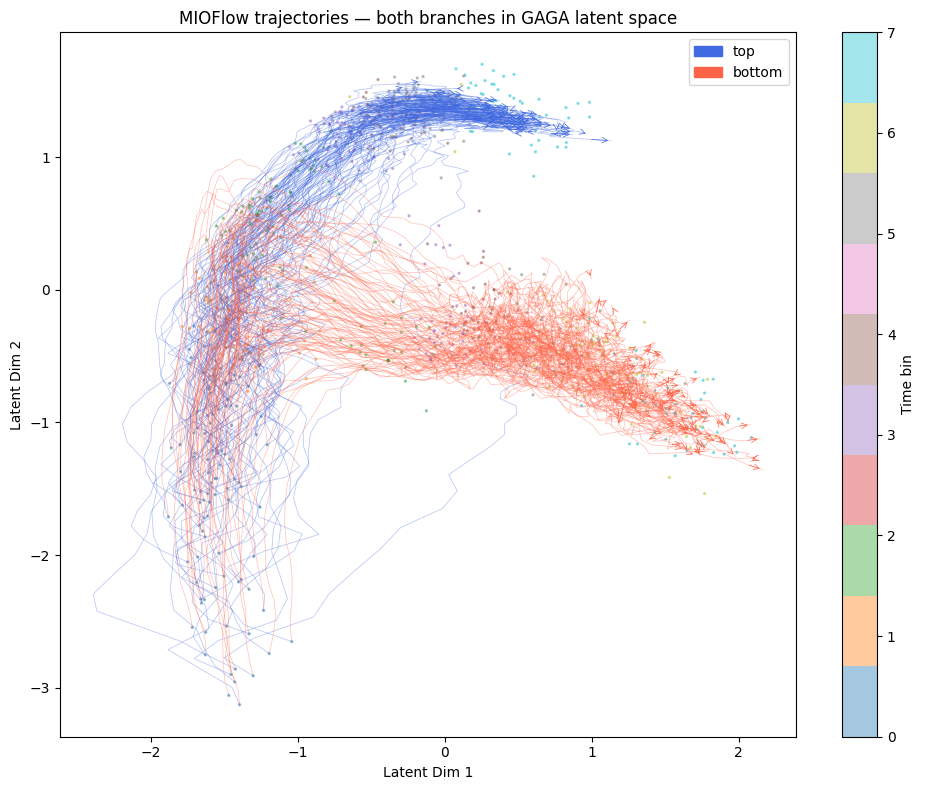

In [19]:
from matplotlib.patches import Patch

branch_colors = {'top': 'royalblue', 'bottom': 'tomato'}

fig, ax = plt.subplots(figsize=(10, 8))

# Background: all cells from full adata
sc_plot = ax.scatter(
    adata.obsm['X_gaga'][:, 0], adata.obsm['X_gaga'][:, 1],
    c=adata.obs[time_column], cmap='tab10', s=2, alpha=0.4,
)
plt.colorbar(sc_plot, ax=ax, label='Time bin')

for branch, model in mioflow_models.items():
    color = branch_colors[branch]
    for traj in model.trajectories.transpose(1, 0, 2):
        ax.plot(traj[:, 0], traj[:, 1], alpha=0.4, linewidth=0.5, color=color)
        ax.annotate(
            '', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
            arrowprops=dict(arrowstyle='->', color=color, lw=0.5, mutation_scale=10),
        )

# Legend patches

ax.legend(handles=[Patch(color=c, label=b) for b, c in branch_colors.items()])
ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_title('MIOFlow trajectories — both branches in GAGA latent space')
plt.tight_layout()
plt.show()


## 6. Decode to Gene Space

`decode_to_gene_space()` maps trajectories through the chain:

**GAGA latent → GAGA decoder → PCA space (inverse scaler) → gene space**

Returns shape **`(n_bins, n_trajectories, n_genes)`**.

In [20]:
trajectories_gene_space = {
    branch: model.decode_to_gene_space()
    for branch, model in mioflow_models.items()
}
# Shape per branch: (n_bins, n_trajectories, n_genes)
# Combined along trajectory axis for shared analyses:
trajectories_gene_space_all = np.concatenate(
    list(trajectories_gene_space.values()), axis=1
)
print('Per-branch shapes:', {b: t.shape for b, t in trajectories_gene_space.items()})
print('Combined shape (n_bins, n_traj_total, n_genes):', trajectories_gene_space_all.shape)


Per-branch shapes: {'top': (100, 100, 100), 'bottom': (100, 100, 100)}
Combined shape (n_bins, n_traj_total, n_genes): (100, 200, 100)


## 7. Gene Trends — Top Highly-Variable Genes

We plot the mean expression (± std) over all trajectories at each time bin.

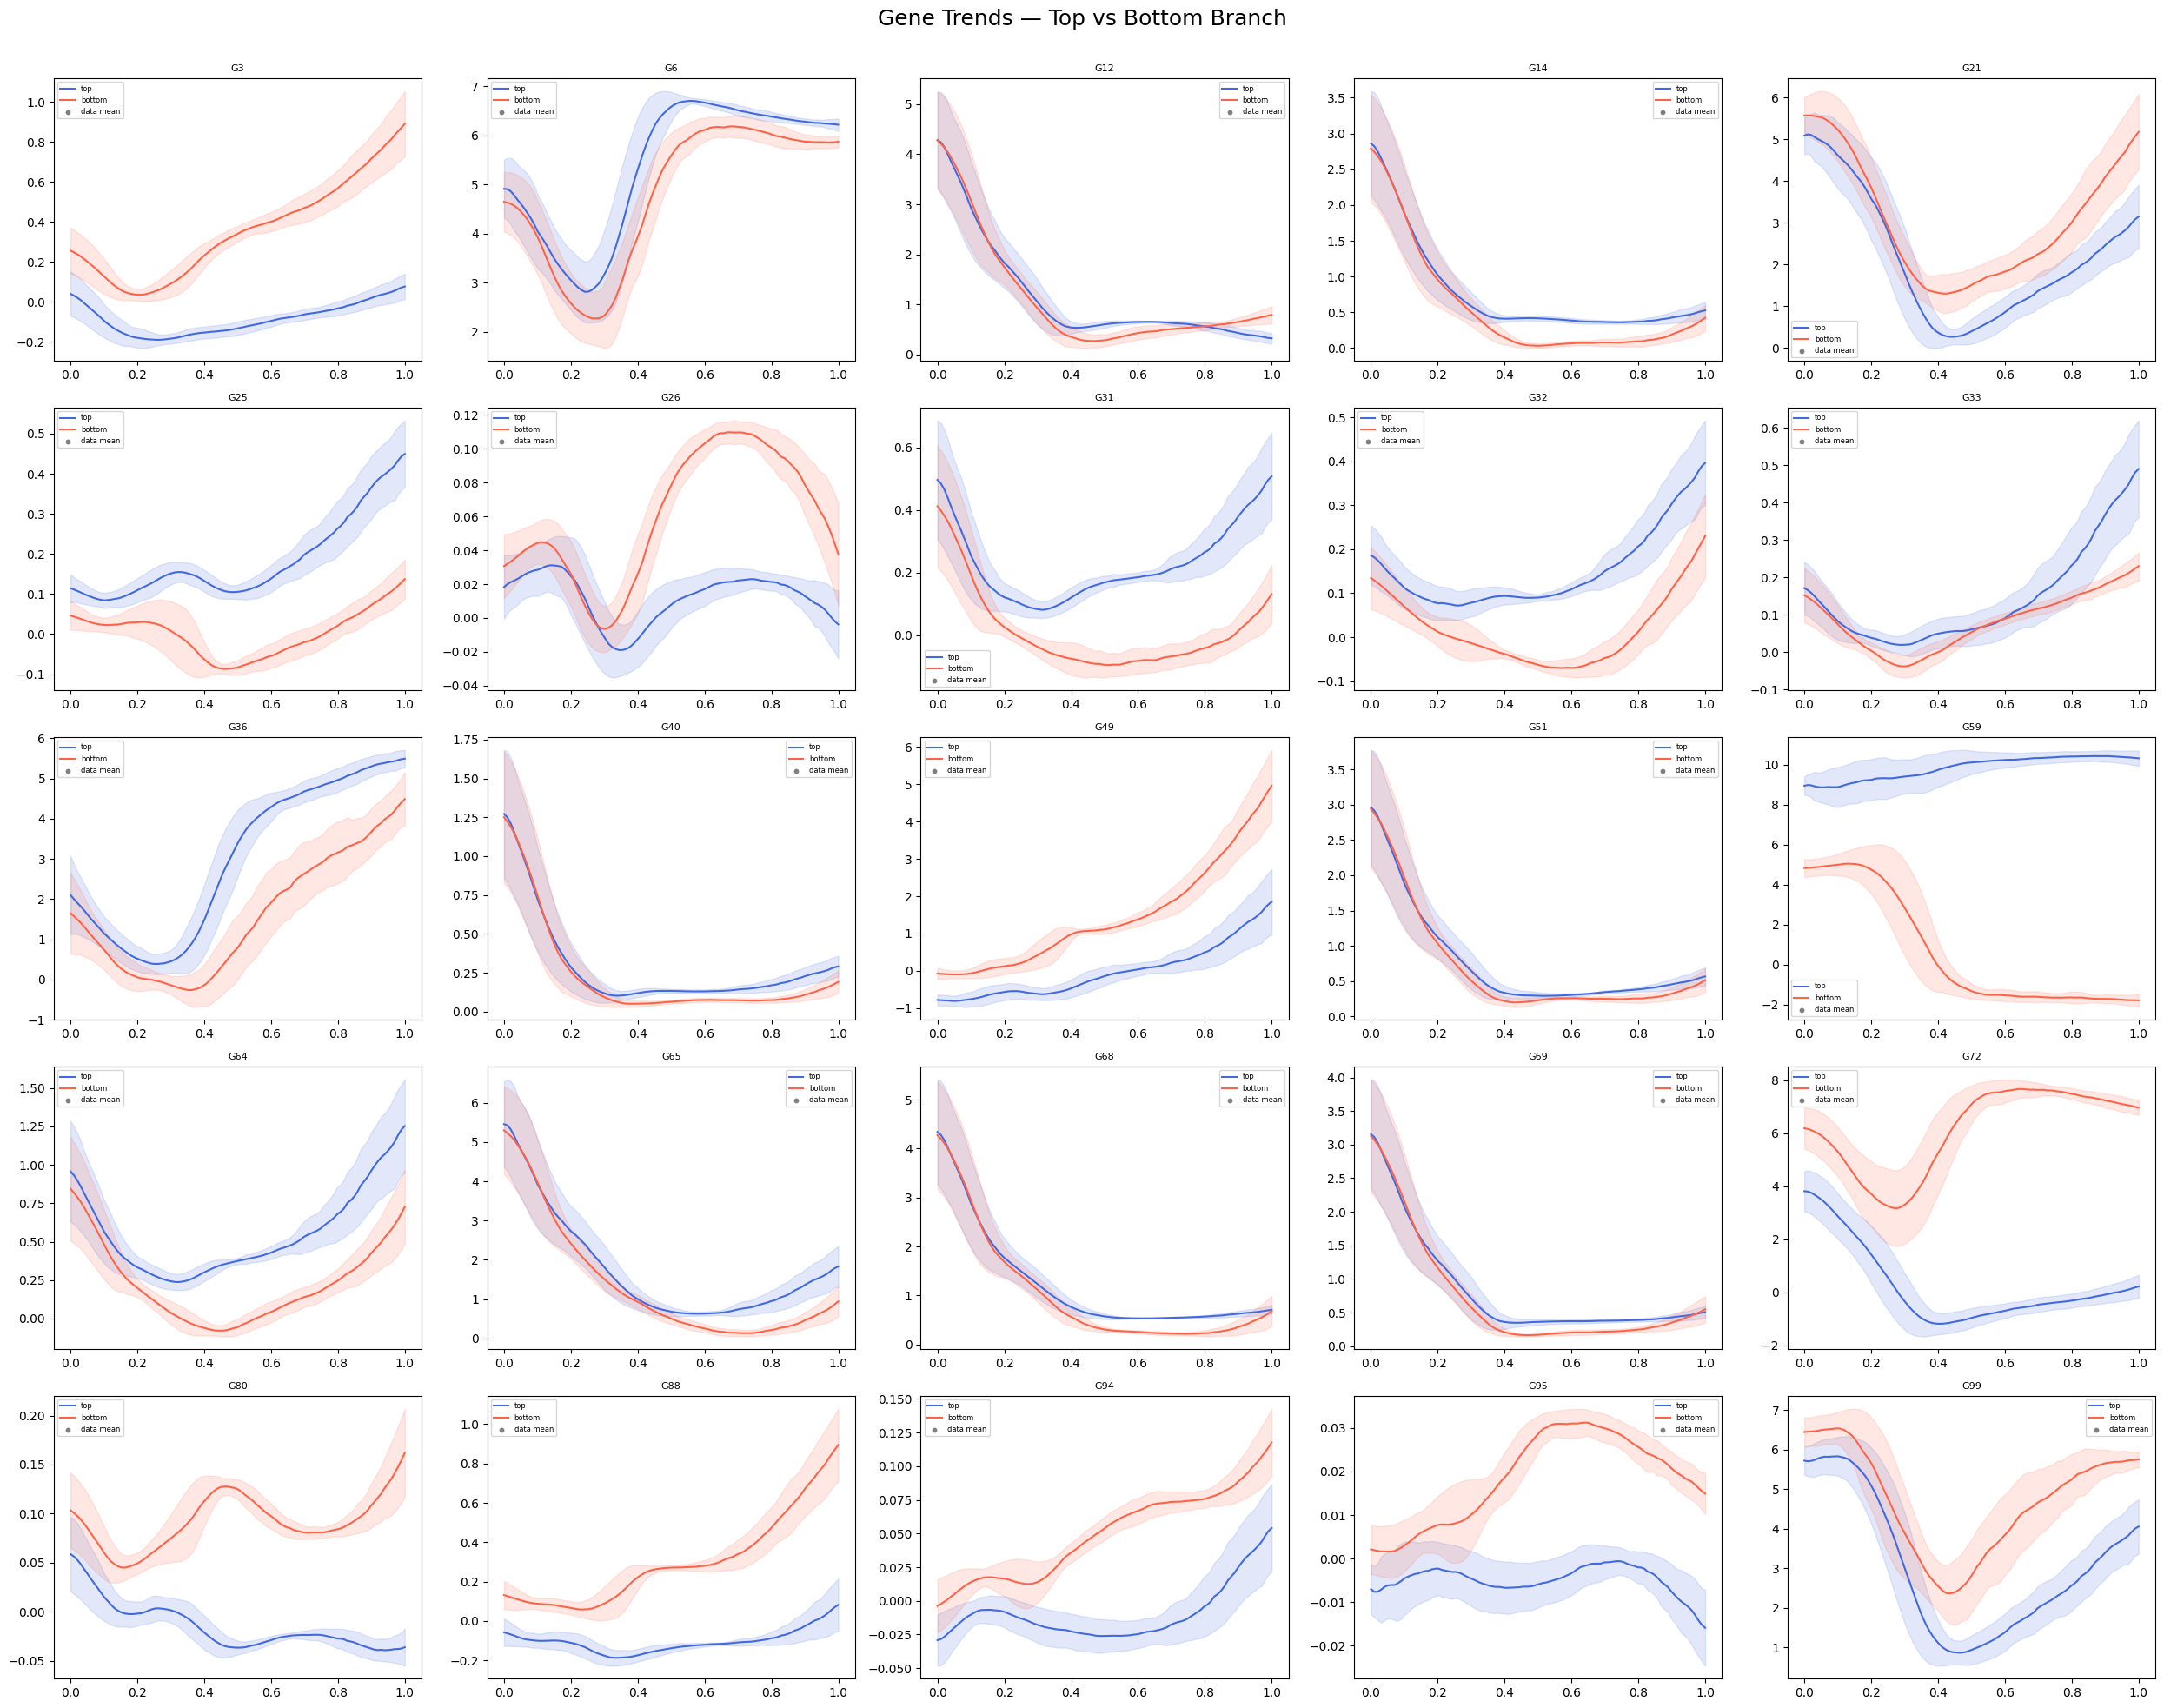

In [21]:
sc.pp.highly_variable_genes(adata, n_top_genes=25)
example_genes     = adata.var_names[adata.var['highly_variable']]
example_gene_mask = adata.var_names.isin(example_genes)

branch_colors = {'top': 'royalblue', 'bottom': 'tomato'}
x_time = np.linspace(0, 1, list(mioflow_models.values())[0].trajectories.shape[0])

# Original data aggregated by time (from full adata)
t = adata.obs[time_column].astype(float)
obs_time_norm = (t - t.min()) / (t.max() - t.min())
adata_sel = adata[:, example_gene_mask]
data_df   = pd.DataFrame(adata_sel.X.toarray(), columns=example_genes)
data_df['t'] = obs_time_norm
data_mean = data_df.groupby('t').mean()

n_genes = len(example_genes)
n_cols  = int(np.ceil(np.sqrt(n_genes)))
n_rows  = int(np.ceil(n_genes / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, gene in enumerate(example_genes):
    ax = axes[i]
    for branch, tgs in trajectories_gene_space.items():
        decoded = tgs[:, :, example_gene_mask][:, :, i]   # (n_bins,)
        mean = decoded.mean(axis=1)
        std  = decoded.std(axis=1)
        color = branch_colors[branch]
        ax.plot(x_time, mean, color=color, label=branch)
        ax.fill_between(x_time, mean - std, mean + std, alpha=0.15, color=color)
    ax.scatter(data_mean.index, data_mean[gene], s=10, color='grey', label='data mean', zorder=3)
    ax.set_title(gene, fontsize=8)
    ax.legend(fontsize=6)

for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Gene Trends — Top vs Bottom Branch', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


## 8. Single Gene of Interest

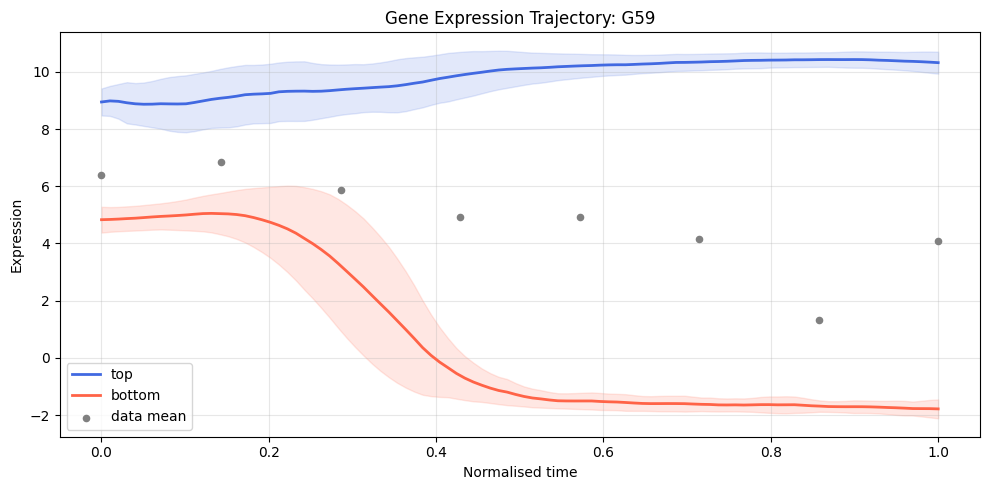

In [22]:
interest_gene = 'G59'
branch_colors = {'top': 'royalblue', 'bottom': 'tomato'}

gene_idx  = list(adata.var_names).index(interest_gene)
x_time    = np.linspace(0, 1, list(mioflow_models.values())[0].trajectories.shape[0])

# Original data mean
orig_df = pd.DataFrame({
    'expression': adata[:, interest_gene].X.toarray().flatten(),
    'time':       obs_time_norm,
})
orig_mean = orig_df.groupby('time')['expression'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
for branch, tgs in trajectories_gene_space.items():
    gene_traj = tgs[:, :, gene_idx]          # (n_bins, n_traj)
    mean = gene_traj.mean(axis=1)
    std  = gene_traj.std(axis=1)
    color = branch_colors[branch]
    ax.plot(x_time, mean, linewidth=2, color=color, label=branch)
    ax.fill_between(x_time, mean - std, mean + std, alpha=0.15, color=color)

ax.scatter(orig_mean.index, orig_mean.values, s=20, color='grey', label='data mean', zorder=3)
ax.set_xlabel('Normalised time')
ax.set_ylabel('Expression')
ax.set_title(f'Gene Expression Trajectory: {interest_gene}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Save Trajectories in Gene Space

In [23]:
# import numpy as np

# # Save per-branch arrays and the combined array as a single .npz file.
# # Keys: 'top', 'bottom', 'all'  →  shape (n_bins, n_traj, n_genes)
# np.savez(
#     'trajectories_gene_space.npz',
#     **trajectories_gene_space,           # 'top' and 'bottom' keys
#     all=trajectories_gene_space_all,
# )
# print('Saved trajectories_gene_space.npz')
# print({k: v.shape for k, v in trajectories_gene_space.items()})
# print('Combined:', trajectories_gene_space_all.shape)
